# 8.1 FGSM 공격

정상 이미지에 노이즈를 더해 머신러닝 모델을 헷갈리게 하는 이미지가
바로 적대적 예제(Adversarial Example) 입니다.
이 프로젝트에선 Fast Gradient Sign Method, 즉 줄여서 FGSM이라는 방식으로
적대적 예제를 생성해 미리 학습이 완료된 딥러닝 모델을 공격해보도록 하겠습니다.

In [1]:
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image
import json

In [2]:
import matplotlib.pyplot as plt

## 학습된 모델 불러오기

In [3]:
model = models.resnet101(pretrained=True)
model.eval()
print(model)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /Users/seoljaehyeok/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## 데이터셋 불러오기

In [4]:
CLASSES = json.load(open('./imagenet_samples/imagenet_classes.json'))
idx2class = [CLASSES[str(i)] for i in range(1000)]

## 이미지 불러오기

In [5]:
# 이미지 불러오기
img = Image.open('imagenet_samples/corgie.jpg')

In [6]:
# 이미지를 텐서로 변환하기
img_transforms = transforms.Compose([
    transforms.Resize((224, 224), Image.BICUBIC),
    transforms.ToTensor(),
])

img_tensor = img_transforms(img)
img_tensor = img_tensor.unsqueeze(0)

print("이미지 텐서 모양:", img_tensor.size())

이미지 텐서 모양: torch.Size([1, 3, 224, 224])


/Users/seoljaehyeok/opt/anaconda3/envs/pytorch/lib/python3.8/site-packages/torchvision/transforms/transforms.py:257: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


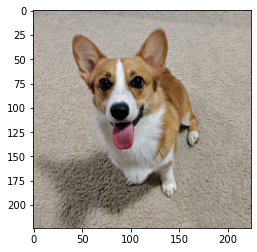

In [7]:
# 시각화를 위해 넘파이 행렬 변환
original_img_view = img_tensor.squeeze(0).detach()  # [1, 3, 244, 244] -> [3, 244, 244]
original_img_view = original_img_view.transpose(0,2).transpose(0,1).numpy()

# 텐서 시각화
plt.imshow(original_img_view)

## 공격 전 성능 확인하기


In [8]:
output = model(img_tensor)
prediction = output.max(1, keepdim=False)[1]

prediction_idx = prediction.item()
prediction_name = idx2class[prediction_idx]

print("예측된 레이블 번호:", prediction_idx)
print("레이블 이름:", prediction_name)

예측된 레이블 번호: 263
레이블 이름: Pembroke, Pembroke Welsh corgi


## FGSM 공격 함수 정의

In [9]:
def fgsm_attack(image, epsilon, gradient):
    # 기울기값의 원소의 sign 값을 구함
    sign_gradient = gradient.sign()
    # 이미지 각 픽셀의 값을 sign_gradient 방향으로 epsilon 만큼 조절
    perturbed_image = image + epsilon * sign_gradient
    # [0,1] 범위를 벗어나는 값을 조절
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

## 적대적 예제 생성

In [10]:
# 이미지의 기울기값을 구하도록 설정
img_tensor.requires_grad_(True)

# 이미지를 모델에 통과시킴
output = model(img_tensor)

# 오차값 구하기 (레이블 263은 웰시코기)
loss = F.nll_loss(output, torch.tensor([263])) 

# 기울기값 구하기
model.zero_grad()
loss.backward()

# 이미지의 기울기값을 추출
gradient = img_tensor.grad.data

# FGSM 공격으로 적대적 예제 생성
epsilon = 0.03
perturbed_data = fgsm_attack(img_tensor, epsilon, gradient)

# 생성된 적대적 예제를 모델에 통과시킴
output = model(perturbed_data)

## 적대적 예제 성능 확인

In [11]:
perturbed_prediction = output.max(1, keepdim=True)[1]

perturbed_prediction_idx = perturbed_prediction.item()
perturbed_prediction_name = idx2class[perturbed_prediction_idx]

print("예측된 레이블 번호:", perturbed_prediction_idx)
print("레이블 이름:", perturbed_prediction_name)

예측된 레이블 번호: 172
레이블 이름: whippet


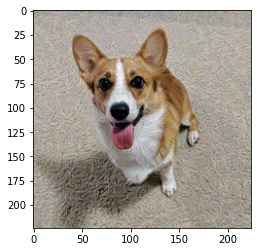

In [12]:
# 시각화를 위해 넘파이 행렬 변환
perturbed_data_view = perturbed_data.squeeze(0).detach()
perturbed_data_view = perturbed_data_view.transpose(0,2).transpose(0,1).numpy()

plt.imshow(perturbed_data_view)

## 원본과 적대적 예제 비교

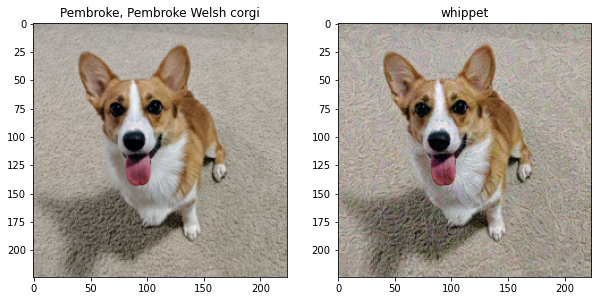

In [13]:
f, a = plt.subplots(1, 2, figsize=(10, 10))

# 원본
a[0].set_title(prediction_name)
a[0].imshow(original_img_view)

# 적대적 예제
a[1].set_title(perturbed_prediction_name)
a[1].imshow(perturbed_data_view)

plt.show()